# Overview
The notebook is setup to reproduce some of the results published by MIT in https://arxiv.org/pdf/1802.02604.pdf and made popular in media sites like: https://www.healthdatamanagement.com/news/mit-algorithm-speeds-process-of-image-registration

The challenge here is to see how the results look on their test datasets and see how the performance is using K80 GPU's provided by Kaggle. Furthre notebooks could go and compare these results to those from standard approaches using ITK/SimpleITK and even OpenCV-based image registration

In [1]:
%matplotlib inline
import os, sys
import glob
import cv2

# third party
import tensorflow as tf
import scipy.io as sio
import numpy as np
from keras.backend.tensorflow_backend import set_session
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
vm_dir = '/Users/lalithnag/00-code/voxelmorph/ct_scans/voxelmorph-master'
sys.path.append(os.path.join(vm_dir, 'src')) # add source

# add all folders under ../ext directory
sys.path.append(os.path.join(vm_dir, 'ext', 'medipy-lib'))

In [3]:
import medipy
import networks
from medipy.metrics import dice

import datagenerators

# Setup the Network
The network is designed for specific dimensions and in particular the pretrained values expect these dimensions and kernel count. If we want to use it without retrainined we are forced to stick to these sizes / depths

In [32]:
# params for the vm2 model
vol_size=(160,192,224)
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,3]

# Load Atlas Data
Here is the atlas dataset that we load as our reference or fixed-image against which we register everything else. We load the labels as well since they help with the DICE scoring later.

In [ ]:
atlas = np.load(os.path.join(vm_dir, 'data', 'atlas_norm.npz'))
atlas_vol = atlas['vol']

## Magic 

In [74]:
def centerCrop(x, crop_h, crop_w=None, pos=2.):
    
    """
    Crops the image to the size given by the user, based on 
    the position parameter

    Inputs:
    -x: Image to be cropped
    -crop_h: Height to be cropped
    -crop_y: Width to be cropped
    -pos: Speficies how to crop the image
     If pos = 'left', then the image is cropped to the left third
     If pos = 'right' then the image is cropped to the right third
     If pos = 'center' then the image is cropped in the center

    Returns:
    -cropped_img = Cropped Image
    
    """
    h, w = x.shape[:2] # True dims of image

    j = int(round((h - crop_h) / pos))
    i = int(round((w - crop_w) / pos))

    cropped_img = x[j:j + crop_h, i:i + crop_w]
    return cropped_img

In [85]:
def concat(path, which, start, end):
    
    concat = np.zeros((160, 192, 224))
    
    ctr = start
    
    for i in range(end-start):
        
        image_path = os.path.join(path, which + 'rect' + str(ctr) + '.bmp')
                             
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        cropped_image = centerCrop(image, 440, 540)
        resized_image = cv2.resize(cropped_image, (224, 192))
        concat[i,:,:] = resized_image
        
        ctr += 1
    
    return concat

In [86]:
path = '/Users/lalithnag/00-code/voxelmorph/sample_rect_frames'
which = 'left'
start = 23
end = 183

concat_left = concat(path, which, start, end)
print(concat_left.shape)

atlas_vol = concat_left

(160, 192, 224)


In [87]:
atlas_vol = np.expand_dims(np.expand_dims(atlas_vol, 0), -1)
print(atlas_vol.shape)

(1, 160, 192, 224, 1)


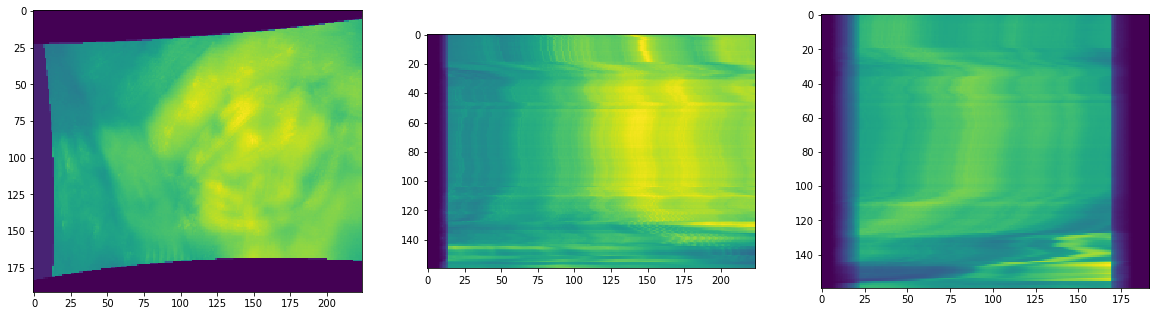

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(atlas_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(atlas_vol[0, :, :, :, 0], 2))

# Load the Model
Here we create the model and load in the pretrained weights

In [73]:
net = networks.unet(vol_size, nf_enc, nf_dec)
net.load_weights(os.path.join(vm_dir, 'models', 'vm2_cc.h5'))
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 160, 192, 224 0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
conv3d_36 (Conv3D)              (None, 80, 96, 112,  880         concatenate_18[0][0]             
__________

# Load Test Data
The test data are what we try to register to the original image. In this case another brain image with the same resolution and dimensions. 

In [89]:
path = '/Users/lalithnag/00-code/voxelmorph/sample_rect_frames'
which = 'right'
start = 23
end = 183

concat_right = concat(path, which, start, end)

In [90]:
xx = np.arange(vol_size[1])
yy = np.arange(vol_size[0])
zz = np.arange(vol_size[2])
grid = np.rollaxis(np.array(np.meshgrid(xx, yy, zz)), 0, 4)

#X_vol, _ = datagenerators.load_example_by_name(os.path.join(vm_dir, 'data', 'test_vol.npz'), os.path.join(vm_dir, 'data', 'test_seg.npz'))

X = concat_right
X_vol = X[np.newaxis, ..., np.newaxis]

#X_vol = concat
print(X_vol.shape)

(1, 160, 192, 224, 1)


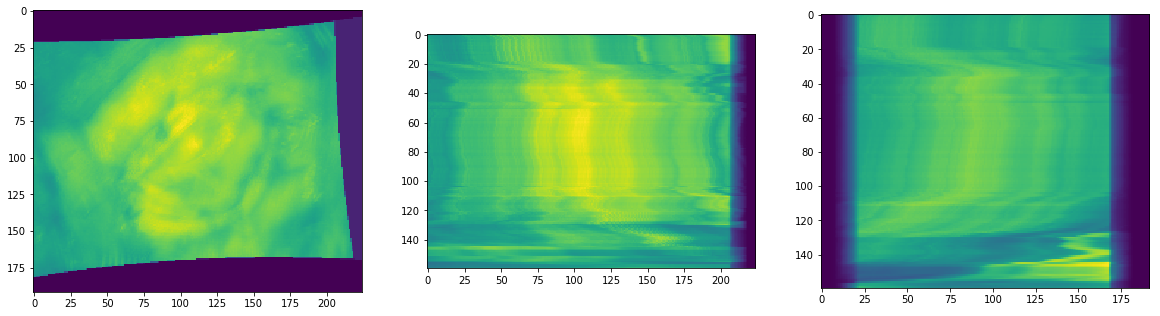

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(X_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(X_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(X_vol[0, :, :, :, 0], 2))

In [92]:
%%time
pred = net.predict([X_vol, atlas_vol])

CPU times: user 1min 44s, sys: 1min 55s, total: 3min 39s
Wall time: 3min 36s


# Show Displacement Maps

In [1]:
# Warp segments with flow
flow = pred[1][0, :, :, :, :]
flow_sd = np.std(flow)
v_args = dict(cmap = 'RdBu', vmin = -flow_sd, vmax = +flow_sd)
fig, m_axs = plt.subplots(3, 3, figsize = (20, 10))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(np.mean(flow[:, :, :, i], 0), **v_args)
    ax1.set_title('xyz'[i]+' flow')
    ax2.imshow(np.mean(flow[:, :, :, i], 1), **v_args)
    ax3.imshow(np.mean(flow[:, :, :, i], 2), **v_args)
    
print(flow.shape)

NameError: name 'pred' is not defined

## Show Flow Field
Here we show the flow field as a quiver map

In [94]:
def meshgridnd_like(in_img,
                    rng_func=range):
    new_shape = list(in_img.shape)
    all_range = [rng_func(i_len) for i_len in new_shape]
    return tuple([x_arr.swapaxes(0, 1) for x_arr in np.meshgrid(*all_range)])

(160, 192, 224, 3)


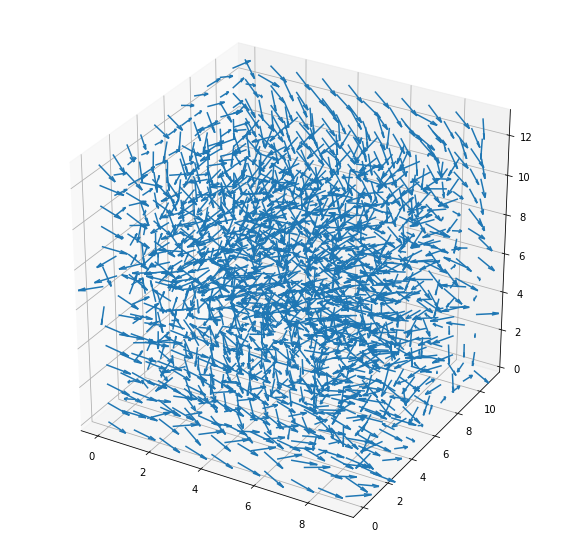

In [95]:
from mpl_toolkits.mplot3d import axes3d
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.9,
          normalize=True)

print(flow.shape)

* Note: Dice score cannot be calculated because we don't have labels and we don't have the segmentation volume